<a href="https://colab.research.google.com/github/harshraj22/DeepLearning/blob/main/submissions/HackerEarth%3A%20%5BSnake%20In%20The%20Hood%5D/hackerearths_snakes_in_the_hood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

- Contest link [here](https://www.hackerearth.com/challenges/competitive/hackerearth-deep-learning-challenge-snake-breed-detection/machine-learning/identify-the-snake-breed-5-66d9a9f5/)

- Transfer Learning using resnet50 with 2 epochs gives score of 7.07897 on leaderboard

# Contents


1.   [Load data using kaggle api](#getting-kaggle-data)
2.   [Play with data](#play-with-data)
3.   [Training code](#training-code)
    * [Create dataset](#create-dataset)
    * [Create model](#create-model)
    * [Training starts](#training-starts)
4.   [Prediction](#prediction)
5.   [Results](#details-scores-result)







## Getting data from kaggle via api <a name="getting-kaggle-data"></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [1]:
import os

os.chdir('/content/drive/My Drive/Hackerearth')
os.getcwd()

'/content/drive/My Drive/Hackerearth'

In [ ]:
! kaggle datasets download -d hotsonhonet/hackerearths-snakes-in-the-hood

 87% 83.0M/95.9M [00:01<00:00, 71.6MB/s]
100% 95.9M/95.9M [00:01<00:00, 70.9MB/s]


In [ ]:
! ls && pwd

hackerearths-snakes-in-the-hood.zip
/content/drive/My Drive/Hackerearth


In [ ]:
! unzip hackerearths-snakes-in-the-hood.zip

## Play around with data <a name="play-with-data"></a>

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd 
import numpy as np
import torch 
import torch.nn as nn

In [4]:
df = pd.read_csv('/content/drive/My Drive/Hackerearth/dataset/train.csv')
df.head()

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


In [6]:
df.groupby('breed').count()

,image_id
breed,
agkistrodon-contortrix,206
agkistrodon-piscivorus,147
coluber-constrictor,129
crotalus-atrox,354
crotalus-horridus,142
crotalus-ruber,77
crotalus-scutulatus,63
crotalus-viridis,83
diadophis-punctatus,184


In [45]:
# number of unique breeds

len(df['breed'].unique())

35

In [46]:
labels = list(df['breed'].unique())

In [47]:
indexToLabel = labels
labelToIndex = dict((label, index) for index, label in enumerate(labels))

### Split data into train and val 

In [48]:
# df['split'] = np.random.randn(df.shape[0], 1)

# msk = np.random.rand(len(df)) <= 0.8
# train_df = df[msk].reset_index().drop('index', axis=1)
# val_df = df[~msk].reset_index().drop('index', axis=1)

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['breed'])

In [49]:
len(train_df)/ (len(train_df) + len(val_df)) # 70% for train

0.7999273783587509

In [50]:
train_df.reset_index(inplace=True)
train_df = train_df[['image_id', 'breed']]

train_df.head()

,image_id,breed
0,cf6439884f,diadophis-punctatus
1,068e50d81c,crotalus-scutulatus
2,8b21d4442a,thamnophis-proximus
3,19674bd84f,crotalus-atrox
4,2a6931e68b,storeria-dekayi


In [51]:
val_df.reset_index(inplace=True)
val_df = val_df[['image_id', 'breed']]

val_df.head()

,image_id,breed
0,53bb5f2c11,masticophis-flagellum
1,e0b85d8ff1,thamnophis-sirtalis
2,595d548bec,thamnophis-marcianus
3,1cb835b1af,pantherophis-obsoletus
4,c4d645c566,agkistrodon-contortrix


## Training process starts <a name="training-code"></a>

In [52]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2

#### create dataset <a name="create-dataset"></a>

In [53]:
class ImgData(Dataset):
  def __init__(self, csv_df, root_dir, transform=None):
    self.csv = csv_df
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.csv)

  def __getitem__(self, idx):
    img = cv2.imread(self.root_dir + self.csv['image_id'][idx] + '.jpg')
    label = labelToIndex[self.csv['breed'][idx]]

    if self.transform:
      img = self.transform(img)

    return {'img': img, 'label': label, 'id': self.csv['image_id'][idx]}

In [54]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])

In [77]:
# Average image width and height is around 128, 128. 
# to make our dataset fit to the pretrained model, we are resizing each
# image to (299, 299)

# Most images have snake at the center :)

# Data  augumentation to make our model more robust.
data_transform = {
    "train": transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((299,299)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomRotation(25),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    "val": transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize((299, 299)),
          transforms.ToTensor(),
          normalize
    ])
    }

In [70]:
snakeTrainDataset = ImgData(train_df, '/content/drive/My Drive/Hackerearth/dataset/train/', data_transform['train'])
snakeValDataset = ImgData(val_df, '/content/drive/My Drive/Hackerearth/dataset/train/', data_transform['val'])

In [71]:
snakeDataloader = {'train': DataLoader(snakeTrainDataset, batch_size=64, num_workers=4, shuffle=True),
                   'val': DataLoader(snakeValDataset, batch_size=64, num_workers=4, shuffle=True)}

#### create model <a name='create-model'></a>
using transfer learning

In [72]:
from torchvision.models import resnet50, resnet101
from torch.nn import functional as F
import torch.optim as optim

from InceptionResnet_v2 import inceptionresnetv2
# Source Implementation of InceptionResnetV2: https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/inceptionresnetv2.py


In [60]:
# already downloaded weights
! cp modelsWeights/inceptionresnetv2-520b38e4.pth /root/.cache/torch/hub/checkpoints/inceptionresnetv2-520b38e4.pth

model = inceptionresnetv2()

In [78]:
# Don't train first few layers,

for param in model.parameters():
  param.requires_grad = False

In [62]:
num_class = len(indexToLabel)

In [63]:
model.last_linear = nn.Sequential(
    nn.Linear(1536, 700),
    nn.ReLU(inplace=True),
    nn.Linear(700, num_class)
)

In [64]:
model

InceptionResNetV2(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [ ]:
# if os.path.exists('/content/drive/My Drive/Hackerearth/model-resnet101.t7'):
#   model.load_state_dict(torch.load('/content/drive/My Drive/Hackerearth/model-resnet101.t7'))
# else:
#   print('No saved weights')

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda', index=0)

In [66]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
optimizer = optim.Adam(model.last_linear.parameters(), lr=0.01)

In [67]:
# from torch.optim.lr_scheduler import StepLR  
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, patience=4, threshold=0.01, verbose=True)

#### Training starts <a name='training-starts'></a>

In [76]:
from tqdm.autonotebook import tqdm
from copy import deepcopy
from sklearn.metrics import f1_score

n_epoch = 40
model.train()
epoch_losses = {
    'val': [],
    'train': []
}

epoch_accs = {
    'val': [],
    'train': []
}

best_acc = 0.0
best_model = deepcopy(model.state_dict())


for epoch in range(n_epoch):
  epoch_loss = 0.0
  epoch_acc = 0.0

  outputs = []
  targets = []
  print('=' * 25, '[Epoch:', epoch+1, '/', n_epoch, ']', '=' * 25)

  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
    else:
      model.eval()

    running_loss = 0.0
    running_correct = 0.0

    for data in tqdm(snakeDataloader[phase], position=0, leave=False):
      img, label = data['img'], data['label']
      img = img.to(device)
      label = torch.tensor(label).to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(phase=='train'):
        outs = model(img)
        preds = torch.argmax(outs, 1)
        loss = criterion(outs, label)

        if phase == 'train':
          loss.backward()
          optimizer.step()
          
        running_loss += loss.item() * img.size()[0]
        running_correct += torch.sum(preds == label.data)

        if phase == 'val':
          outputs.append(preds.cpu().detach().numpy())
          targets.append(label.cpu().detach().numpy())
    
    epoch_loss = running_loss / len(snakeDataloader[phase])
    epoch_acc = running_correct.double() / len(snakeDataloader[phase])

    print(f'[{phase}] => Acc: {epoch_acc :.2f}  Loss: {epoch_loss :.2f}')
    if phase == 'val':
      outputs = np.concatenate(outputs)
      targets = np.concatenate(targets)
      print(f"[val] => f1-score {f1_score(outputs, targets, average='weighted') :.2f}")

    epoch_losses[phase].append(epoch_loss)
    epoch_accs[phase].append(epoch_acc)

    if phase == 'val' and epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model = deepcopy(model.state_dict())
    elif phase == 'train':
      scheduler.step(epoch_loss)



========================= [Epoch: 1 / 40 ] =========================


[train] => Acc: 9.87  Loss: 197.66


[val] => Acc: 8.33  Loss: 193.12
[val] => f1-score 0.21
========================= [Epoch: 2 / 40 ] =========================


[train] => Acc: 9.96  Loss: 197.55


[val] => Acc: 10.17  Loss: 189.14
[val] => f1-score 0.24
========================= [Epoch: 3 / 40 ] =========================


[train] => Acc: 10.61  Loss: 194.69


[val] => Acc: 10.33  Loss: 186.62
[val] => f1-score 0.24
========================= [Epoch: 4 / 40 ] =========================


[train] => Acc: 10.71  Loss: 192.30


[val] => Acc: 10.33  Loss: 184.18
[val] => f1-score 0.23
========================= [Epoch: 5 / 40 ] =========================


[train] => Acc: 10.80  Loss: 192.63


[val] => Acc: 10.22  Loss: 184.77
[val] => f1-score 0.23
========================= [Epoch: 6 / 40 ] =========================


[train] => Acc: 11.32  Loss: 189.76


[val] => Acc: 10.78  Loss: 183.86
[val] => f1-score 0.25
========================= [Epoch: 7 / 40 ] =========================


[train] => Acc: 11.30  Loss: 191.43


[val] => Acc: 11.39  Loss: 183.47
[val] => f1-score 0.26
========================= [Epoch: 8 / 40 ] =========================


[train] => Acc: 10.94  Loss: 190.11


[val] => Acc: 10.39  Loss: 188.31
[val] => f1-score 0.25
========================= [Epoch: 9 / 40 ] =========================


[train] => Acc: 11.59  Loss: 188.73


[val] => Acc: 10.39  Loss: 187.94
[val] => f1-score 0.23
========================= [Epoch: 10 / 40 ] =========================


[train] => Acc: 11.71  Loss: 186.18


[val] => Acc: 11.67  Loss: 181.10
[val] => f1-score 0.26
========================= [Epoch: 11 / 40 ] =========================


[train] => Acc: 12.13  Loss: 186.54


[val] => Acc: 11.00  Loss: 182.44
[val] => f1-score 0.26
========================= [Epoch: 12 / 40 ] =========================


[train] => Acc: 12.01  Loss: 185.38


[val] => Acc: 11.61  Loss: 180.56
[val] => f1-score 0.26
========================= [Epoch: 13 / 40 ] =========================


[train] => Acc: 11.84  Loss: 186.53


[val] => Acc: 11.72  Loss: 180.10
[val] => f1-score 0.26
========================= [Epoch: 14 / 40 ] =========================


[train] => Acc: 12.46  Loss: 186.01


[val] => Acc: 12.22  Loss: 179.95
[val] => f1-score 0.27
========================= [Epoch: 15 / 40 ] =========================


[train] => Acc: 12.70  Loss: 185.40
Epoch    18: reducing learning rate of group 0 to 1.0000e-03.


[val] => Acc: 8.50  Loss: 189.18
[val] => f1-score 0.18
========================= [Epoch: 16 / 40 ] =========================


[train] => Acc: 12.57  Loss: 182.22


[val] => Acc: 12.06  Loss: 178.96
[val] => f1-score 0.27
========================= [Epoch: 17 / 40 ] =========================


[train] => Acc: 13.33  Loss: 181.24


[val] => Acc: 11.94  Loss: 179.09
[val] => f1-score 0.27
========================= [Epoch: 18 / 40 ] =========================


[train] => Acc: 12.99  Loss: 180.74


[val] => Acc: 12.39  Loss: 178.72
[val] => f1-score 0.27
========================= [Epoch: 19 / 40 ] =========================


[train] => Acc: 12.86  Loss: 180.44


[val] => Acc: 12.22  Loss: 178.27
[val] => f1-score 0.27
========================= [Epoch: 20 / 40 ] =========================


[train] => Acc: 13.57  Loss: 179.41


[val] => Acc: 12.28  Loss: 178.02
[val] => f1-score 0.28
========================= [Epoch: 21 / 40 ] =========================


[train] => Acc: 13.67  Loss: 179.29


[val] => Acc: 12.06  Loss: 178.14
[val] => f1-score 0.27
========================= [Epoch: 22 / 40 ] =========================


[train] => Acc: 13.67  Loss: 178.88


[val] => Acc: 12.17  Loss: 178.45
[val] => f1-score 0.27
========================= [Epoch: 23 / 40 ] =========================


[train] => Acc: 13.26  Loss: 178.94


[val] => Acc: 12.22  Loss: 178.53
[val] => f1-score 0.28
========================= [Epoch: 24 / 40 ] =========================


[train] => Acc: 13.88  Loss: 178.95


[val] => Acc: 12.39  Loss: 178.48
[val] => f1-score 0.27
========================= [Epoch: 25 / 40 ] =========================


[train] => Acc: 13.67  Loss: 179.69
Epoch    28: reducing learning rate of group 0 to 1.0000e-04.


[val] => Acc: 12.22  Loss: 179.08
[val] => f1-score 0.27
========================= [Epoch: 26 / 40 ] =========================


[train] => Acc: 13.70  Loss: 178.26


[val] => Acc: 12.50  Loss: 178.14
[val] => f1-score 0.28
========================= [Epoch: 27 / 40 ] =========================


[train] => Acc: 13.94  Loss: 177.88


[val] => Acc: 12.44  Loss: 178.49
[val] => f1-score 0.28
========================= [Epoch: 28 / 40 ] =========================


[train] => Acc: 13.52  Loss: 179.22


[val] => Acc: 12.39  Loss: 178.72
[val] => f1-score 0.28
========================= [Epoch: 29 / 40 ] =========================


[train] => Acc: 13.41  Loss: 178.12


[val] => Acc: 12.44  Loss: 178.73
[val] => f1-score 0.28
========================= [Epoch: 30 / 40 ] =========================


[train] => Acc: 13.29  Loss: 178.89
Epoch    33: reducing learning rate of group 0 to 1.0000e-05.


[val] => Acc: 12.17  Loss: 178.07
[val] => f1-score 0.27
========================= [Epoch: 31 / 40 ] =========================


[train] => Acc: 13.29  Loss: 179.10


[val] => Acc: 12.61  Loss: 177.92
[val] => f1-score 0.28
========================= [Epoch: 32 / 40 ] =========================


[train] => Acc: 13.75  Loss: 178.81


[val] => Acc: 12.33  Loss: 178.18
[val] => f1-score 0.28
========================= [Epoch: 33 / 40 ] =========================


[train] => Acc: 13.49  Loss: 179.19


[val] => Acc: 12.44  Loss: 178.39
[val] => f1-score 0.28
========================= [Epoch: 34 / 40 ] =========================


[train] => Acc: 13.57  Loss: 179.25


[val] => Acc: 12.39  Loss: 178.14
[val] => f1-score 0.28
========================= [Epoch: 35 / 40 ] =========================


[train] => Acc: 13.30  Loss: 179.22
Epoch    38: reducing learning rate of group 0 to 1.0000e-06.


[val] => Acc: 12.17  Loss: 177.98
[val] => f1-score 0.27
========================= [Epoch: 36 / 40 ] =========================


[train] => Acc: 14.07  Loss: 177.89


[val] => Acc: 12.72  Loss: 178.16
[val] => f1-score 0.29
========================= [Epoch: 37 / 40 ] =========================


[train] => Acc: 13.54  Loss: 177.95


[val] => Acc: 12.56  Loss: 178.15
[val] => f1-score 0.28
========================= [Epoch: 38 / 40 ] =========================


[train] => Acc: 13.88  Loss: 178.08


[val] => Acc: 12.22  Loss: 178.34
[val] => f1-score 0.27
========================= [Epoch: 39 / 40 ] =========================


[train] => Acc: 13.46  Loss: 178.78


[val] => Acc: 12.06  Loss: 178.88
[val] => f1-score 0.27
========================= [Epoch: 40 / 40 ] =========================


[train] => Acc: 13.57  Loss: 178.27
Epoch    43: reducing learning rate of group 0 to 1.0000e-07.


[val] => Acc: 12.50  Loss: 178.29
[val] => f1-score 0.28


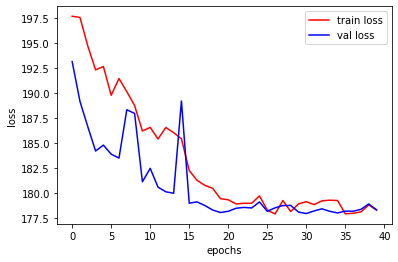

In [79]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses['train'], color='red', label='train loss')
plt.plot(epoch_losses['val'], color='blue', label='val loss')
plt.legend(loc="upper right")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
# model_path = '/content/drive/My Drive/Hackerearth/model-inceptionresnetv2.t7'
# torch.save(model.state_dict(), model_path)

## Prediction <a name='prediction'></a>

In [ ]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    normalize
])

In [ ]:
test_csv = pd.read_csv('/content/drive/My Drive/Hackerearth/dataset/test.csv')

In [ ]:
snakeTestDataset = ImgData(test_csv, '/content/drive/My Drive/Hackerearth/dataset/test/', test_transform)

In [ ]:
snakeTestDataloader = DataLoader(snakeTestDataset, batch_size=32) 

In [ ]:
preds = pd.DataFrame(columns=['image_id', 'breed'])

In [ ]:
model.eval()
from tqdm import tqdm

for index, data in enumerate(tqdm(snakeTestDataloader, position=0, leave=True)):
  img, label, id = data['img'], data['label'], data['id']
  img = img.to(device)
  outs = model(img)
  cls = torch.argmax(outs, dim=1)

  for img_id, img_cls in zip(data['id'], cls):
    preds = preds.append({'image_id': img_id, 'breed': indexToLabel[img_cls]}, ignore_index=True)

100%|██████████| 74/74 [20:41<00:00, 16.78s/it]


In [ ]:
# preds['image_id'] = [id[0] for id in preds['image_id']]

In [ ]:
preds.head()

,image_id,breed
0,7ede553357,nerodia-sipedon
1,3500b219e4,nerodia-sipedon
2,d43a78d6d9,crotalus-atrox
3,1f36f26994,storeria-dekayi
4,8cb85fc58e,crotalus-atrox


In [ ]:
set(preds['image_id']) == set(test_csv['image_id']) 

True

In [ ]:
preds.to_csv('preds.csv', index=False) 

In [ ]:
len(preds), len(test_csv)

(2361, 2361)

In [ ]:
preds = preds.tail(2361)

## Details, Scores and result <a name='details-scores-result'></a>

In [ ]:
''' details:
model: InceptionResnetV2
epoch: 40 (with lr_schedular: reduceOnPlateue)
score on leaderboard: 17.01
model weights saved: True
'''

' details:\nmodel: InceptionResnetV2\nepoch: 40 (with lr_schedular: reduceOnPlateue)\nscore on leaderboard: 17.01\nmodel weights saved: True\n'

## RoughWork

In [ ]:
from InceptionResnet_v2 import inceptionresnetv2

In [ ]:
! cp modelsWeights/inceptionresnetv2-520b38e4.pth /root/.cache/torch/hub/checkpoints/inceptionresnetv2-520b38e4.pth

In [ ]:
model = inceptionresnetv2()

In [ ]:
! cp /root/.cache/torch/hub/checkpoints/inceptionresnetv2-520b38e4.pth modelsWeights/

In [ ]:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
model.last_linear = nn.Sequential(
    nn.Linear(1536, 700),
    nn.ReLU(inplace=True),
    nn.Linear(700, num_class)
)

In [ ]:
model

In [ ]:
import torch

In [ ]:
lst = [
       [1, 2, 4],
       [3, 4, 5]
]

In [ ]:
d = torch.tensor(lst)

In [ ]:
preds = torch.argmax(d, 1)

In [ ]:
labels = torch.tensor([1, 2])

In [ ]:
torch.max(d, 1)

torch.return_types.max(values=tensor([4, 5]), indices=tensor([2, 2]))

In [ ]:
torch.sum(labels == preds).item()

1

In [3]:
from IPython.display import Image, display
import pandas as pd

In [7]:
df.head()

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


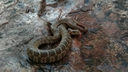

In [8]:
display(Image('/content/drive/My Drive/Hackerearth/dataset/train/' + 'a8b3ad1dde.jpg'))

In [9]:
from random import choice

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

plt.figure(figsize=(120,120))
columns = 3
images = []

<Figure size 8640x8640 with 0 Axes>

In [ ]:

for i in range(10):
  f = choice(df['image_id'])
  images.append(mpimg.imread( '/content/drive/My Drive/Hackerearth/dataset/train/' + f + '.jpg' ))

for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [36]:
from PIL import Image

widths, heights = [], []
from tqdm import tqdm

for f in tqdm(df['image_id']):
  im = Image.open('/content/drive/My Drive/Hackerearth/dataset/train/' + f + '.jpg')
  width, height = im.size
  heights.append(height)
  widths.append(width)

print(im.size)

  7%|▋         | 404/5508 [02:42<38:14,  2.22it/s]

KeyboardInterrupt: ignored

In [38]:
len(widths)

404

In [40]:
import numpy as np
np.mean(heights)

129.60643564356437

In [32]:
df.head(20)

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix
5,d04b95dd67,thamnophis-sirtalis
6,190317f717,crotalus-atrox
7,43e4eb5f81,lampropeltis-triangulum
8,4fd6a5e5fa,crotalus-horridus
9,a57df436ac,crotalus-ruber
